## ZVAR Utilities: Example Notebook

This notebook demonstrates the use of the ZVAR utilities. The utilities are a set of functions that can be used to interact with the ZVAR data products, more specifically the variability candidate datasets, which are a subset of the periodicity data product, limited to "truly" periodic sources. To which we add crossmatch information with other catalogs: Gaia DR3, Pan-STARRS, AllWISE, and 2MASS.


In this notebook, we'll demonstate how to:
- Load the variability candidate dataset
- Based on their Gaia cross-match plot them on a color-magnitude diagram
- Extract sub-sets of the data based on their variability properties
- Retrieve and plot the light curves of a subset of sources, folded by their best period
- Run Schuster & FPW algorithms to find the best period on a source's light curve (*Optional step, as it can be computationally expensive and periods are already provided in the dataset. More of a technical demonstration*)

---

### Imports

First, we need to import zvar_utils. To avoid having to pip install zvar_utils, we can use the following code to import the module from the parent directory (assuming the notebook is in a subdirectory of the zvar_utils directory):

In [1]:
import sys
sys.path.append("..")

from zvar_utils.candidate import import_from_parquet, VariabilityCandidate
from zvar_utils.lightcurves import freq_grid, retrieve_objs_lightcurve
from zvar_utils.plot import (
    plot_gaia_cmd,
    plot_folded_lightcurve,
    plot_periodicity,
    plot_folded_photometry_mean_per_bin,
    plot_folded_photometry_median_per_bin,
)
from zvar_utils.files import get_ssh_client
from zvar_utils.stats import median_abs_deviation, get_string_length, get_entropy

/Users/theodlz/projects/ZVAR-Utilities/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


*This is very convenient, since you can easily make changes to the zvar_utils module, and re-import it just by restarting the kernel.*

Then, we can import the other "external" modules we'll use in this notebook.

In [2]:
import glob
import fpwperiodic as fpw
import matplotlib.pyplot as plt
import numpy as np

from astropy.timeseries import LombScargle
from matplotlib.backends.backend_pdf import PdfPages

### Data access initialization (local & remote)

Here, we'll set up a few variables to:
- Define the path to where the periodicity candidate datasets are stored **locally**
- Define the path to where the lightcurve data is stored **locally**
- Define the path to where the lightcurve data is stored **on the server** (magnetar, or hypernova)
- Define the hostname, username, and password (or path to ssh key) to access the server

*Notes:*

*- If you don't have access to the server, you can still run the notebooks by not passing the `ssh_client` to the lightcurve retrieval functions. This will limit you to only using the local data.*

*- While you can use a password directly, it is recommended to use an ssh key, as it is more secure. In this notebook, we use an ssh key but this can easily be changed (in the following cell) to use a password.*

In [4]:
path_candidates = '../data/demo_data/candidates'
path_lc = '../data/demo_data/lc'
remote_path_lc = '/data/matchfiles'

host = 'magnetar.caltech.edu'
username = 'tdulaz'
pkey_path = '/Users/theodlz/.ssh/magnetar'

ssh_client = get_ssh_client(host, username=username, pkey_path=pkey_path)

# OR, you can use a password directly, but it is not recommended:
# password = 'your_password'
# ssh_client = get_ssh_client(host, username=username, password=password)

Successfully connected to magnetar.caltech.edu


For this example notebook we will use the demo data provided along with ZVAR-Utilities. It is hosted in it's own GitHub repo, added to this one as a submodule in the `data` directory. We need to make sure that it is initialized and up-to-date. For that, the following cell will check that for you and provide instructions on how to fetch/update it if needed.

In [ ]:
error_message = (
    "❌ No candidate files found in the demo_data submodule. ❌"
    "\n🔧 Run `git submodule update --init --recursive` at the root of the repository to clone the submodule, and try again.🔧"
    "\nℹ️ PS: If git lfs isn't installed, you will need to install it: https://docs.github.com/en/repositories/working-with-files/managing-large-files/installing-git-large-file-storage ℹ️"
)
demo_data_path = '../data/demo_data'
if not glob.glob(f"{demo_data_path}/candidates/*/*.parquet"):
    raise Exception(error_message)
else:
    print("✅ Found candidate files in the demo_data submodule. ✅")

### Variability Candidates

Let's load the variability candidates for a given field & band (here we use field 648, r-band):

In [5]:
band = ['r']
fields = [648]
candidate_list: list[VariabilityCandidate] = []
for field in fields:
    for band in band:
        for file in glob.glob(f'{path_candidates}/{field:04d}/*_z{band}.parquet', recursive=True):
            candidate_list.extend(import_from_parquet(file))
            
print(f"Loaded {len(candidate_list)} candidates")

Loaded 1124 candidates


Let's take a quick look at the data, which is a list of `VariabilityCandidate` objects (a class defined in `zvar_utils`).

In [6]:
first_candidate = candidate_list[0]
print(first_candidate)

ID: 143513570184190869, RA: 357.0184326171875, Dec: 29.591903686523438, Valid: 0.9425837397575378, Best M: 5, freq: 9.353532791137695, FAP: 0.000494051469615342 (field: 648, ccd: 4, quad: 3)
    PS1: G: 20.59±0.03, R: 19.39±0.02, I: 18.46±0.01, Z: 17.93±0.01, Y: 17.72±0.01
    Gaia: G: 19.11, BP: 20.21, RP: 18.08, Parallax: 1.45±0.24, PMRA: 2.99±0.24, PMDEC: -3.02±0.17
    2MASS: J: 16.73±nan, H: 15.78±nan, K: 15.75±nan
    AllWISE: W1: 15.64±0.04, W2: 15.61±0.12, W3: 12.70±nan, W4: 8.98±nan


As you can see, printing the `VariabilityCandidate` class will give you a summary of the object, including his crossmatch information with other catalogs (if available).

However, this is a regular python class so you can also print all of it's attributes and methods with:

In [7]:
# variable and method names (exluding private ones that start with '__')
print([x for x in dir(first_candidate) if not x.startswith('__')])

# you can see that the ps1, gaia, 2mass, and allwise data are their own objects
# Let's look at their types
print(type(first_candidate.ps1))
print(type(first_candidate.gaia))
print(type(first_candidate.twomass))
print(type(first_candidate.allwise))

# and then let's look at their attributes and methods
print([x for x in dir(first_candidate.ps1) if not x.startswith('__')])
print([x for x in dir(first_candidate.gaia) if not x.startswith('__')])
print([x for x in dir(first_candidate.twomass) if not x.startswith('__')])
print([x for x in dir(first_candidate.allwise) if not x.startswith('__')])

['allwise', 'best_M', 'ccd', 'dec', 'fap', 'field', 'freq', 'gaia', 'id', 'ps1', 'quad', 'ra', 'set_2mass', 'set_allwise', 'set_gaia', 'set_ps1', 'twomass', 'valid']
<class 'zvar_utils.candidate.PS1Match'>
<class 'zvar_utils.candidate.GaiaMatch'>
<class 'zvar_utils.candidate.TwoMASSMatch'>
<class 'zvar_utils.candidate.AllWISEMatch'>
['g', 'g_err', 'i', 'i_err', 'id', 'r', 'r_err', 'y', 'y_err', 'z', 'z_err']
['BP', 'BP_RP', 'G', 'MG', 'RP', 'add_MG', 'add_bp_rp', 'id', 'parallax', 'parallax_error', 'pmdec', 'pmdec_error', 'pmra', 'pmra_error']
['h', 'h_err', 'id', 'j', 'j_err', 'k', 'k_err']
['id', 'w1', 'w1_err', 'w2', 'w2_err', 'w3', 'w3_err', 'w4', 'w4_err']


PS1, Gaia, 2MASS, and AllWISE crossmatch information are found as their own python class (as shown in the previous cell). You can also print them which will format the information in a more human-readable way, just like the `VariabilityCandidate` class:

In [8]:
print(first_candidate.ps1)
print(first_candidate.gaia)
print(first_candidate.twomass)
print(first_candidate.allwise)

G: 20.59±0.03, R: 19.39±0.02, I: 18.46±0.01, Z: 17.93±0.01, Y: 17.72±0.01
G: 19.11, BP: 20.21, RP: 18.08, Parallax: 1.45±0.24, PMRA: 2.99±0.24, PMDEC: -3.02±0.17
J: 16.73±nan, H: 15.78±nan, K: 15.75±nan
W1: 15.64±0.04, W2: 15.61±0.12, W3: 12.70±nan, W4: 8.98±nan


Now that we have an idea of what the data looks like, let's create 4 subsets of candidates based on their Gaia data and/or period:
- Red candidates (gaia.BP_RP > 3.0)
- White Dwarf candidates (gaia.BP_RP < 2.0 & gaia.MG > 10.0)
- Giant candidates (gaia.BP_RP > 1.0 & gaia.MG < 3.0)
- Short Period candidates (period < 1 hour)

In [9]:
red_candidates = [
    candidate for candidate in candidate_list
    if candidate.gaia.BP_RP is not None and candidate.gaia.BP_RP > 3.0
]

wd_candidates = [
    candidate for candidate in candidate_list
    if (
        candidate.gaia.BP_RP is not None and candidate.gaia.BP_RP < 2.0
        and candidate.gaia.MG is not None and candidate.gaia.MG > 10.0
    )
]

giant_candidates = [
    candidate for candidate in candidate_list
    if (
        candidate.gaia.BP_RP is not None and candidate.gaia.BP_RP > 1.0
        and candidate.gaia.MG is not None and candidate.gaia.MG < 3.0
    )
]

short_candidates = [
    candidate for candidate in candidate_list
    if 1/candidate.freq < 1/24
]

In the following sections, we'll focus on a subset of these candidates (giants), and plot their light curves. But first, let's see how many candidates we have in each subset:

In [10]:
print(f"Found {len(red_candidates)} red candidates")
print(f"Found {len(wd_candidates)} white dwarf candidates")
print(f"Found {len(giant_candidates)} giant candidates")
print(f"Found {len(short_candidates)} short period candidates")

Found 11 red candidates
Found 9 white dwarf candidates
Found 27 giant candidates
Found 7 short period candidates


### Gaia Color-Magnitude Diagram (CMD)

Now that we have an idea of what the data looks like, let's plot the candidates (that have valid Gaia data) on a color-magnitude diagram (CMD). We'll plot the full dataset first, and then focus on the giants subset.

/Users/theodlz/projects/ZVAR-Utilities/notebooks/../zvar_utils/plot.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


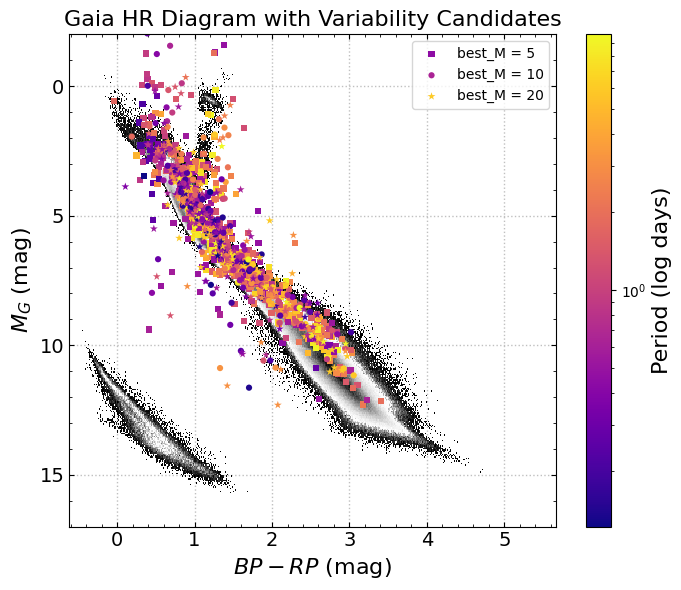

In [11]:
plot_gaia_cmd(candidate_list, figsize=(7,6))

and here is the CMD for the giants subset:

/Users/theodlz/projects/ZVAR-Utilities/notebooks/../zvar_utils/plot.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


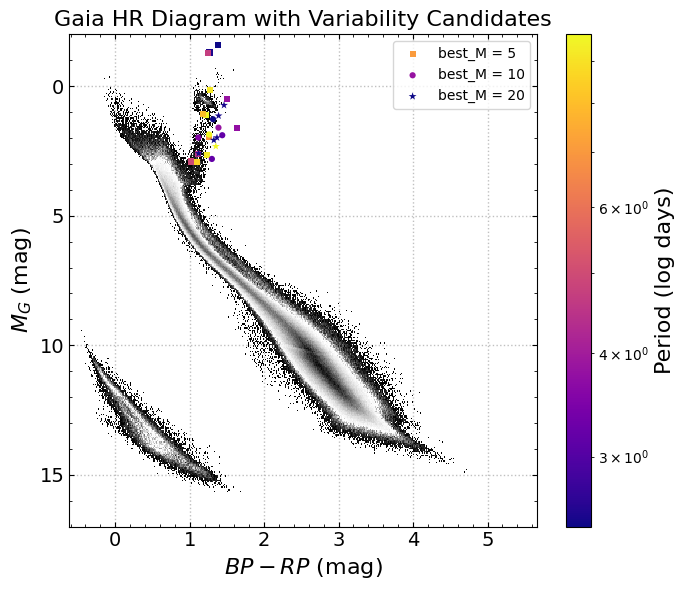

In [12]:
plot_gaia_cmd(giant_candidates, figsize=(7,6))

*Notes:*

*- The Gaia data is not available for all sources, so some sources will not be plotted on the CMD.*

*- The Gaia data in some parts of the sky seems to yield unexpected results (e.g. ZTF field 279), so the CMD may not look as expected in some cases. We suggest looking at the diagram on an entire field before looking at individual subsets, to avoid confusion.*

### Light Curves retrieval, plotting, and statistics

Now that we have an idea of what the candidates metadata looks like, let's retrieve the light curves for a subset of the candidates. We'll focus on the giants subset, and plot their light curves.

*Notes*:

*- In this section, we'll use the `ssh_client` variable defined earlier, to automagically retrieve the light curves from the server, if not available locally. If you don't have access to the server but already have the light curves locally, you can simply **not** pass the `ssh_client` variable to the function.*

*- You'll notice that we pass the `field` to the `retrieve_objs_lightcurve` function. This is because internally we find the overlapping field(s) based on the candidates positions, and retrieve the light curves for all those fields. If you have overlapping field (such as the primary & secondary grid), this could result in us fetching data from multiple fields. Since we already know what field(s) we are looking at in advance, we can optionally specify*

*- The `retrieve_objs_lightcurve` also optionally takes a `bands` parameter, used to restrict in which filters we want to retrieve the light curves. If not specified, it will retrieve in `g` and `r` bands by default. Here we leave it unspecified, so we can later plot the light curves in both bands.*

In [27]:
# let's plot their lightcurves, folded on the best period, both g an r band
all_photometry = retrieve_objs_lightcurve(
    objs=short_candidates + giant_candidates + wd_candidates + red_candidates,
    path_lc=path_lc,
    ssh_client=ssh_client,
    remote_path_lc=remote_path_lc,
    limit_fields=[int(f) for f in fields], # limit to the field we are interested in
    use_position=False, # if False, will use the field, ccd, quad of the candidate (if it exists, otherwise throws an error)
)

Before plotting the light curves, let's take a look at the light curve data we just retrieved. The data is a dictionnary with the candidates' id as keys, and the light curve data as values. The light curve data is simply an array of 4 numpy arrays: `time`, `flux`, `flux_err`, and `filter`, where the `time` is in `BJD` set to 0 at the first observation, the `flux` is in `ADU`, the `flux_err` is in `ADU`, and the `filter` is an integer representing the filter (1 for `g`, 2 for `r`, 3 for `i`). It contains detections and upper limits, and deep-drilling data has been removed already.

In [28]:
phot = all_photometry[red_candidates[0].id]

print(phot.shape) # (4, N) where N is the number of data points

# you can access the time, flux, flux_err, and filter by index
time, flux, flux_err, filter = phot[0], phot[1], phot[2], phot[3]

# or simply destructure the array which is more readable
time, flux, flux_err, filter = phot

(4, 1033)


Now that we know what the light curve data looks like, let's plot the light curves for a subset of the candidates. The next cell selects that subset for the rest of the section.

In [29]:
selected_candidates = giant_candidates

We'll plot the light curves in both `g` and `r` bands, and fold each light curve by the best period found in the variability candidate dataset.

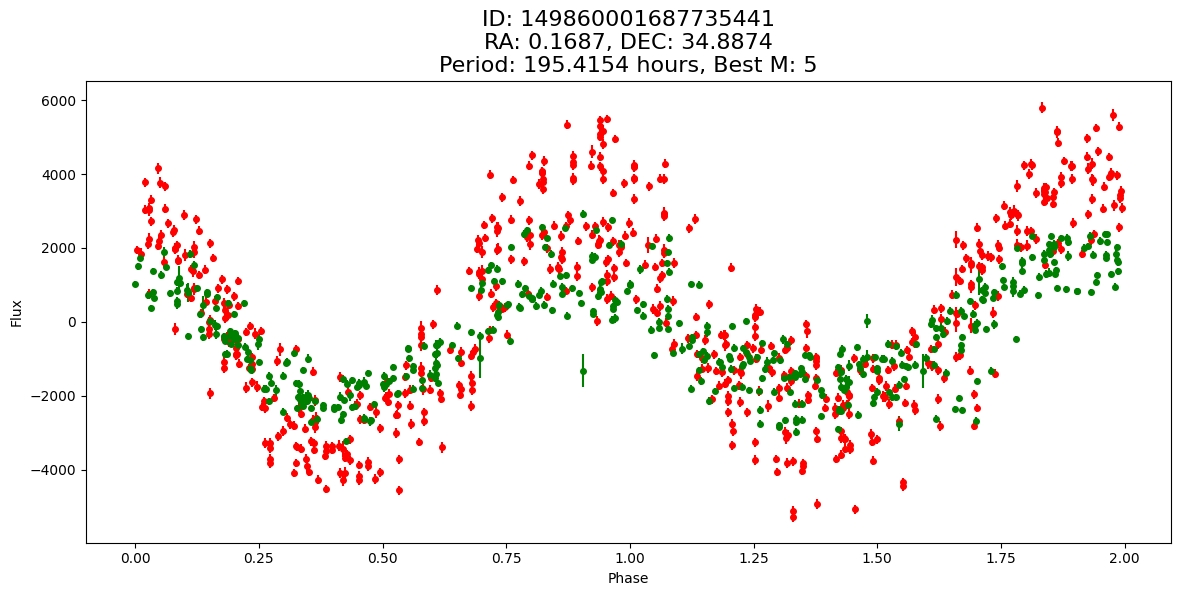

In [28]:
for candidate in selected_candidates[16:17]:
    photometry = all_photometry[candidate.id]
    plot_folded_lightcurve(candidate, photometry, figsize=(14,6))

Optionally, you can also pass a `bins` parameter to the `plot_lightcurves` function, to specify the number of bins to use when folding the light curves. If not specified, no binning is used. A `bin_method` parameter can also be passed to specify the binning method to use ('mean' or  'median'). If not specified, the default is 'mean'. Here's an example:

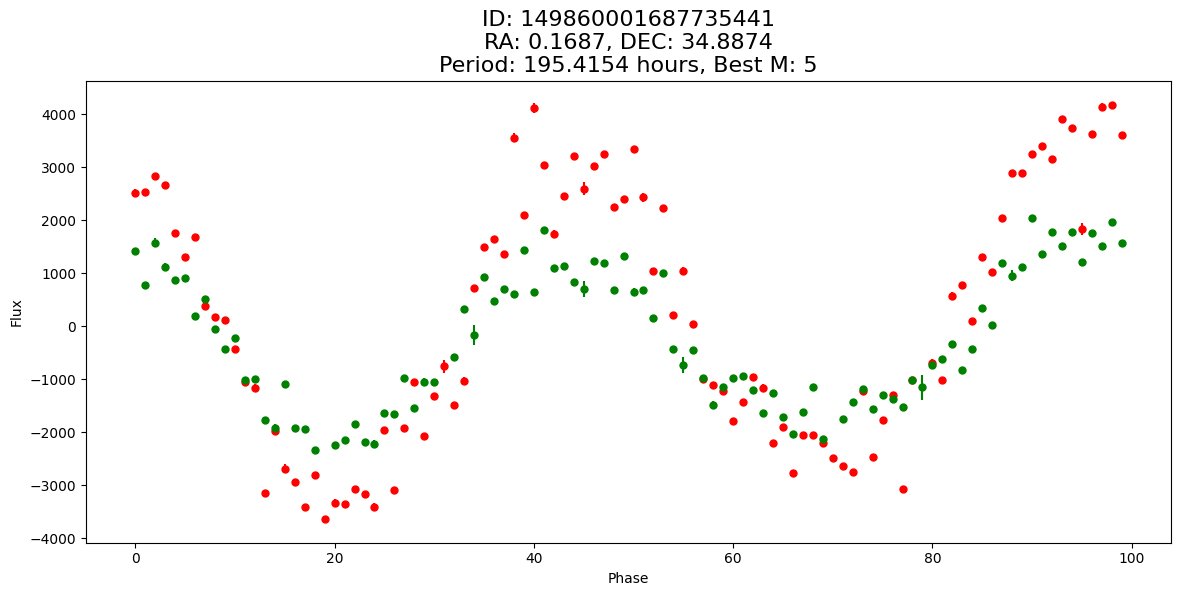

In [36]:
for candidate in selected_candidates[16:17]:
    photometry = all_photometry[candidate.id]
    plot_folded_lightcurve(candidate, photometry, figsize=(14,6), bins=100, bin_method='mean', marker_size=5)

The `plot_folded_lightcurves` optionally takes an ax parameter, which can be used to plot the light curves on a pre-existing figure. Let's try this in the previous cell, to create a grid of light curves, with 3 light curves per row.

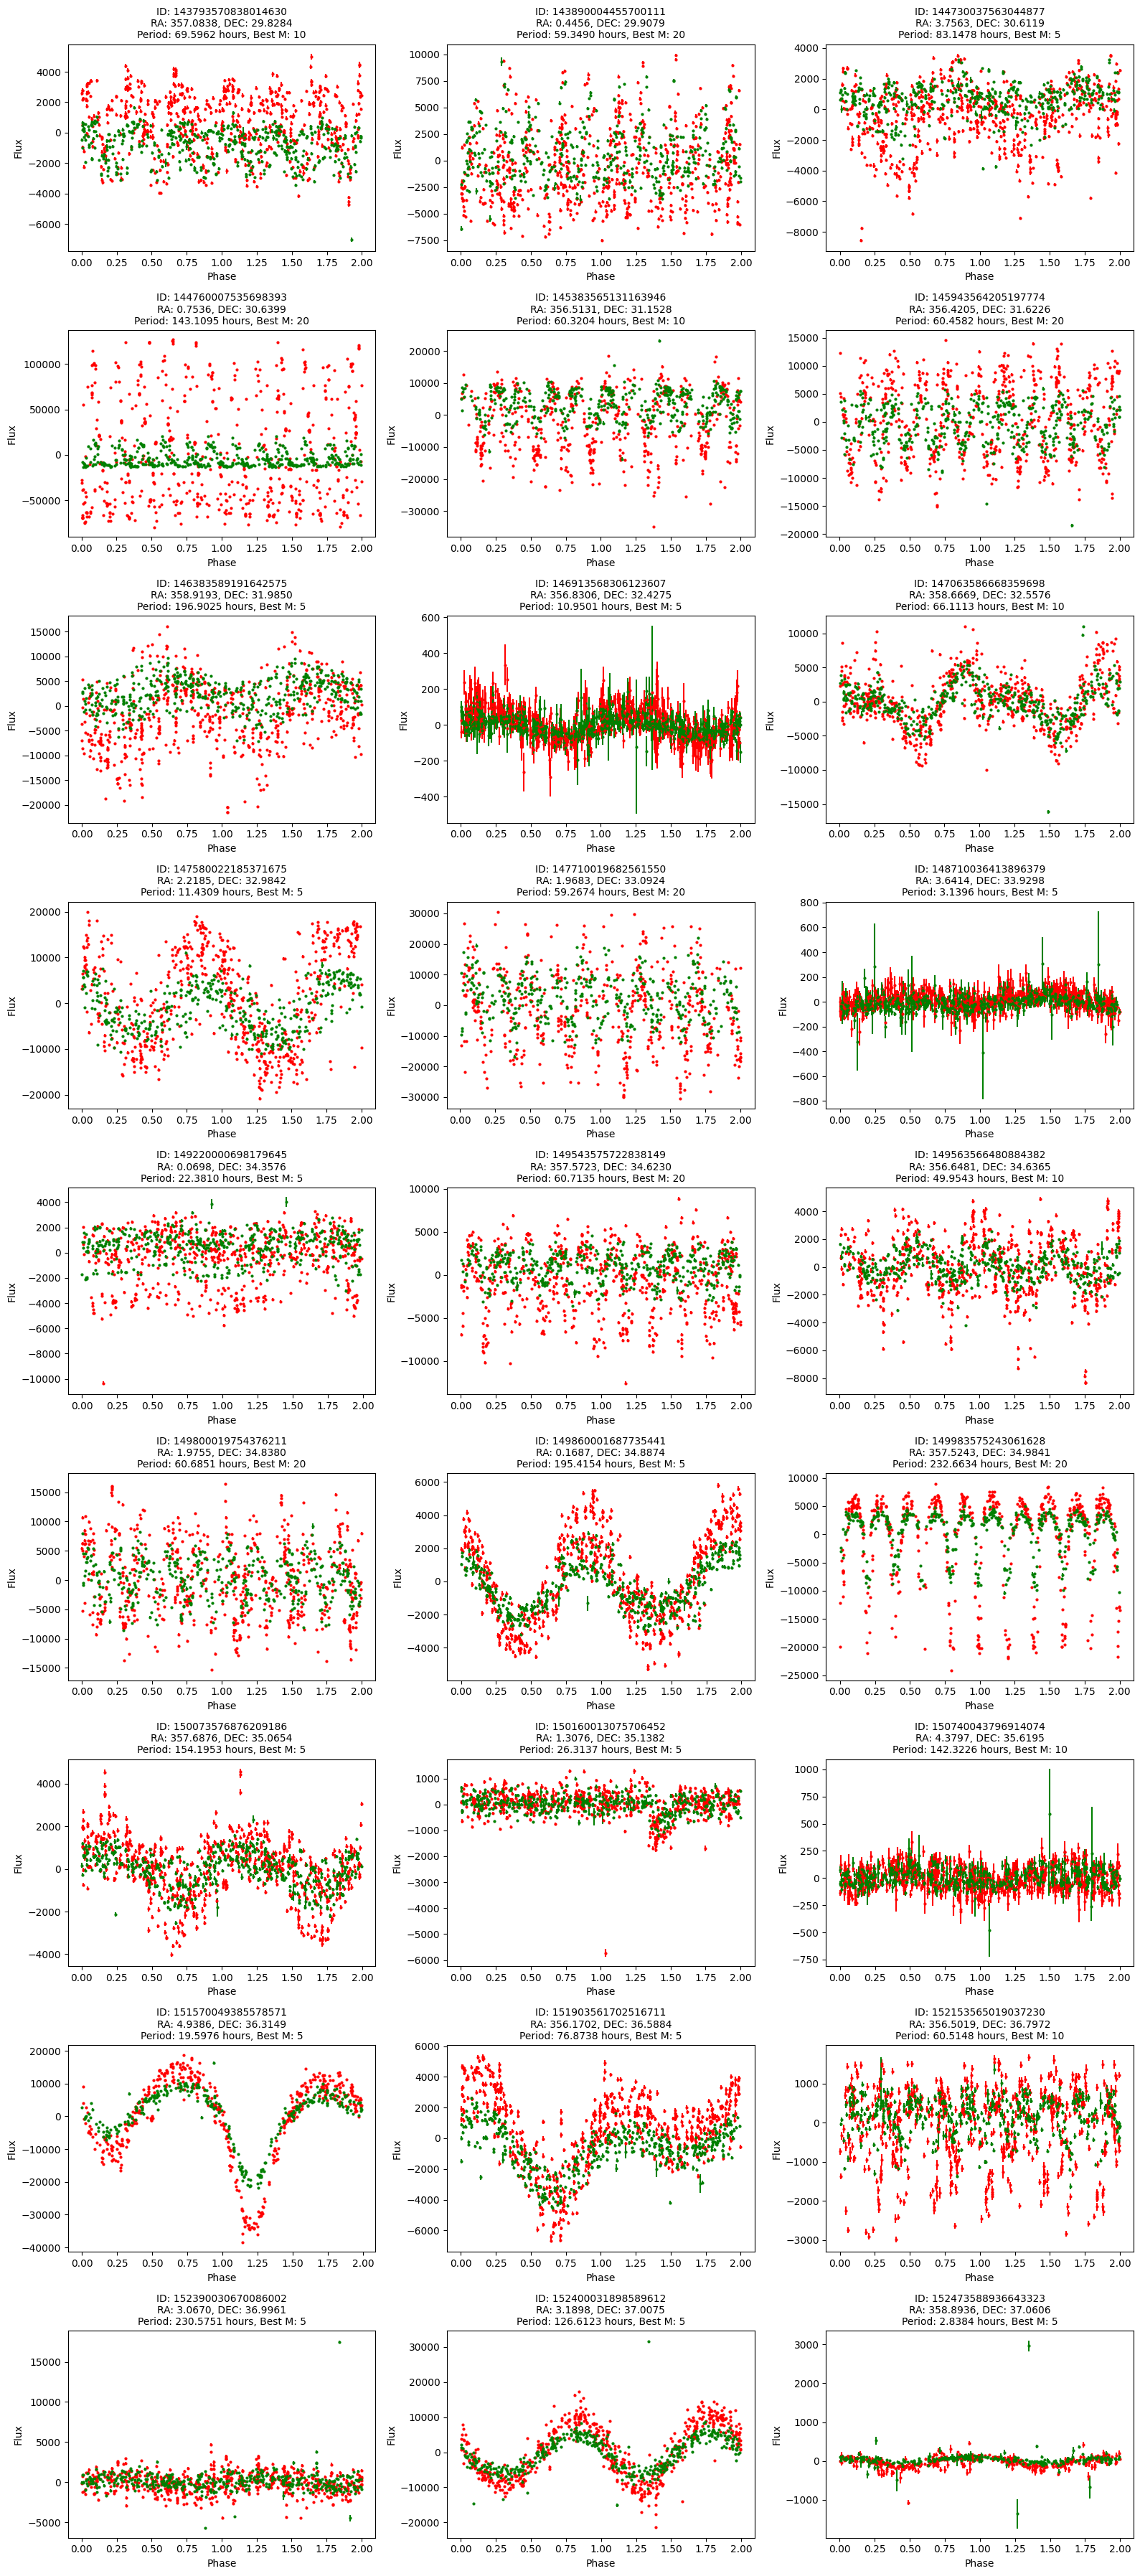

In [37]:
# let's jsut compute how many rows we need to display all the candidates
n_rows = len(selected_candidates) // 3 + (len(selected_candidates) % 3 > 0)

# let's now compute the figsize height, as a function of the number of rows
figsize = (16, 4 * n_rows)

fig, axs = plt.subplots(n_rows, 3, figsize=figsize)
for i, ax in enumerate(axs.flat):
    if i < len(selected_candidates):
        candidate = selected_candidates[i]
        photometry = all_photometry[candidate.id]
        plot_folded_lightcurve(candidate, photometry, ax=ax, show_plot=False, marker_size=2, title_size=10)
    else:
        ax.axis('off')

plt.tight_layout()

Maybe we'd like to save those on a paginated PDF, to share with our colleagues. Here's how you can do that:

In [40]:
pdf_path = '../data/folded_lightcurves.pdf'
max_candidates_per_page = 15 # how many candidates we want to display per page
n_cols = 3 # how many columns we want to display
figsize = (17, 22) # US Letter size in inches (doubled)
with PdfPages(pdf_path) as pdf:
    for i in range(0, len(selected_candidates), max_candidates_per_page):
        fig, axs = plt.subplots(max_candidates_per_page // n_cols, n_cols, figsize=figsize)
        for j, ax in enumerate(axs.flat):
            if i + j < len(selected_candidates):
                candidate = selected_candidates[i + j]
                photometry = all_photometry[candidate.id]
                plot_folded_lightcurve(candidate, photometry, ax=ax, show_plot=False, marker_size=3, title_size=10, bins=100)
            else:
                ax.axis('off')

        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)

/Users/theodlz/projects/ZVAR-Utilities/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/theodlz/projects/ZVAR-Utilities/env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/theodlz/projects/ZVAR-Utilities/notebooks/../zvar_utils/plot.py:227: RuntimeWarning: invalid value encountered in scalar divide
  binned_fluxerr[i, j] = np.sqrt(np.sum(fluxerr[mask] ** 2)) / np.sum(


It can be interesting to plot fold the lightcurve, bin it, and plot the median/mean flux per bin. Here's how to do it:

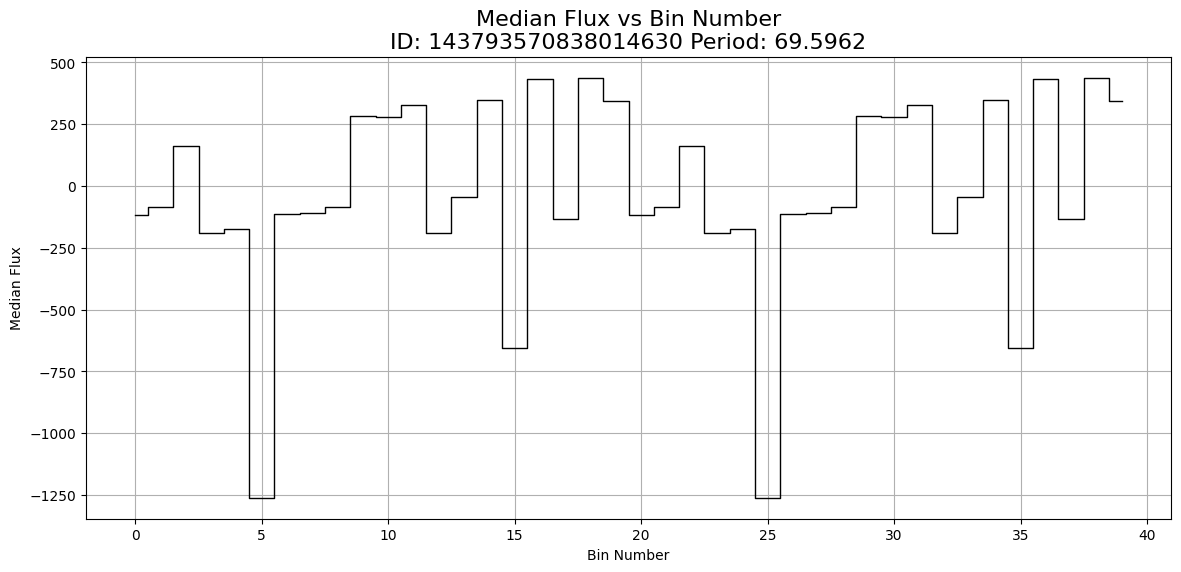

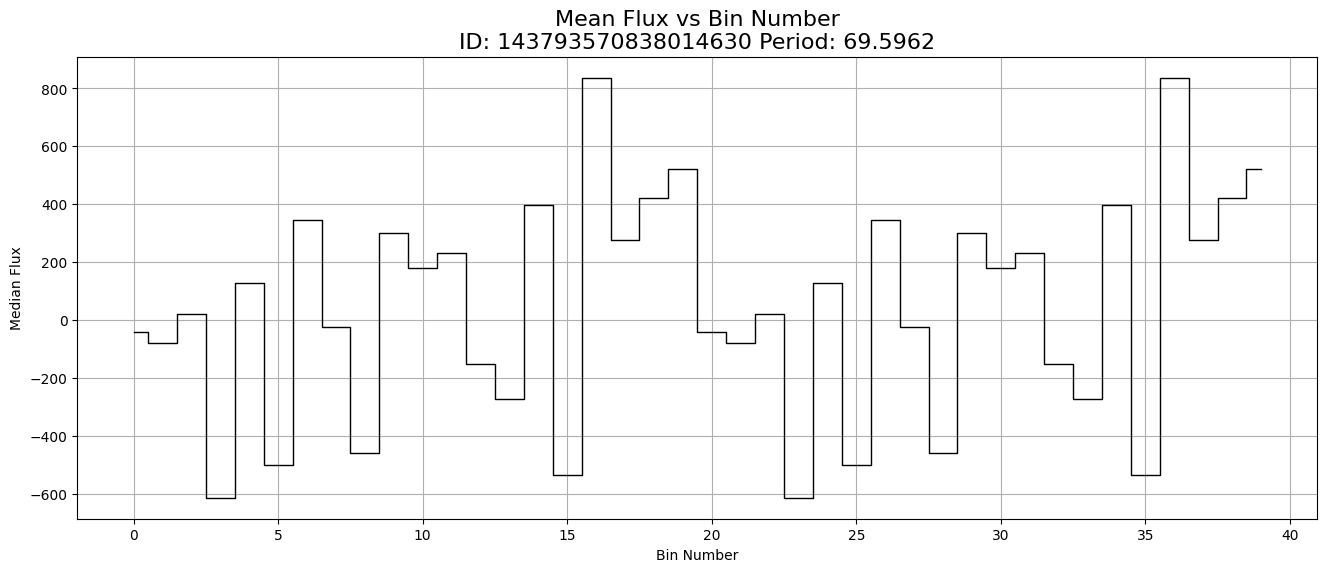

In [41]:
# try it out with a short period candidate
candidate = selected_candidates[0]
# let's plot their lightcurves, folded on the best period, both g an r band
photometry = all_photometry[candidate.id]
num_bins = 20
plot_folded_photometry_median_per_bin(candidate, photometry, num_bins, figsize=(14,6))
plot_folded_photometry_mean_per_bin(candidate, photometry, num_bins, figsize=(16,6))

Now that we started looking at some lightcurve-based statistics/metrics, let's look at 2 other methods from `zvar_utils.stats`:
- `string_length`: This method calculates the string length of a light curve, which is the sum of the lengths of the strings of consecutive detections.
- `entropy`: This method calculates the entropy of a light curve, which is a measure of the randomness of the light curve.

For both, we first fold the light curve by the best period, and then calculate the statistic. These can be used to further filter the candidates based on their light curve properties.

In [42]:
# string length
string_length = get_string_length(candidate, photometry)
print(f"String length of {int(candidate.id)}: {string_length}")

# entropy
entropy, min_entropy, entropy_expect, sigma_expect = get_entropy(candidate, photometry, num_bins=num_bins)
print(f"Entropy of {int(candidate.id)}: {entropy}, {min_entropy}, {entropy_expect}, {sigma_expect}")

String length of 143793570838014630: 1562.1776329281772
Entropy of 143793570838014630: -3.536178505829933, -4.321928094887363, -4.31311148197627, 0.0028604720553629826


### Schuster & FPW algorithms for period finding

In the following section, we show how to run Schuster and FPW to compute periods. This is a simple example and not necessary (at least for FPW) since we already have the best period reported for each candidate. However, it is a good exercise to understand how these algorithms work, and can be useful if you want to compute periods for objects that are not in the dataset.

In this example we will focus on one giant candidate, with id = 151570049385578571 (assuming you are running this notebook on its original field and band: 648, r-band).

*Note: Period finding should be done on one band at a time, so make sure you only keep data for one band when running the algorithms.*

In [39]:
candidate = [c for c in candidate_list if c.id == 151570049385578571][0]
phot = all_photometry[candidate.id]
# we only keep r-band data
phot = phot[:, phot[3] == 2]

First, let's try Schuster:

In [40]:
fgrid = freq_grid(phot[0]) # returns a frequency grid for the given time array

ls_pgram = LombScargle(phot[0].copy(), phot[1].copy(), phot[2].copy()).power(fgrid)
best_period = 1/fgrid[np.argmax(ls_pgram)] / 3600 / 24 # best period in days, where the power is maximized

print(f"Best Schuster period: {best_period*24:.4f} hours")

Best Schuster period: 19.5982 hours


We found a best period at 19.5982 hours, which is almost identical to the best period reported in the dataset (19.5976 hours). Before moving on to FPW, let's plot a panel with the original lightcurve, the periodogram, and the folded lightcurve.

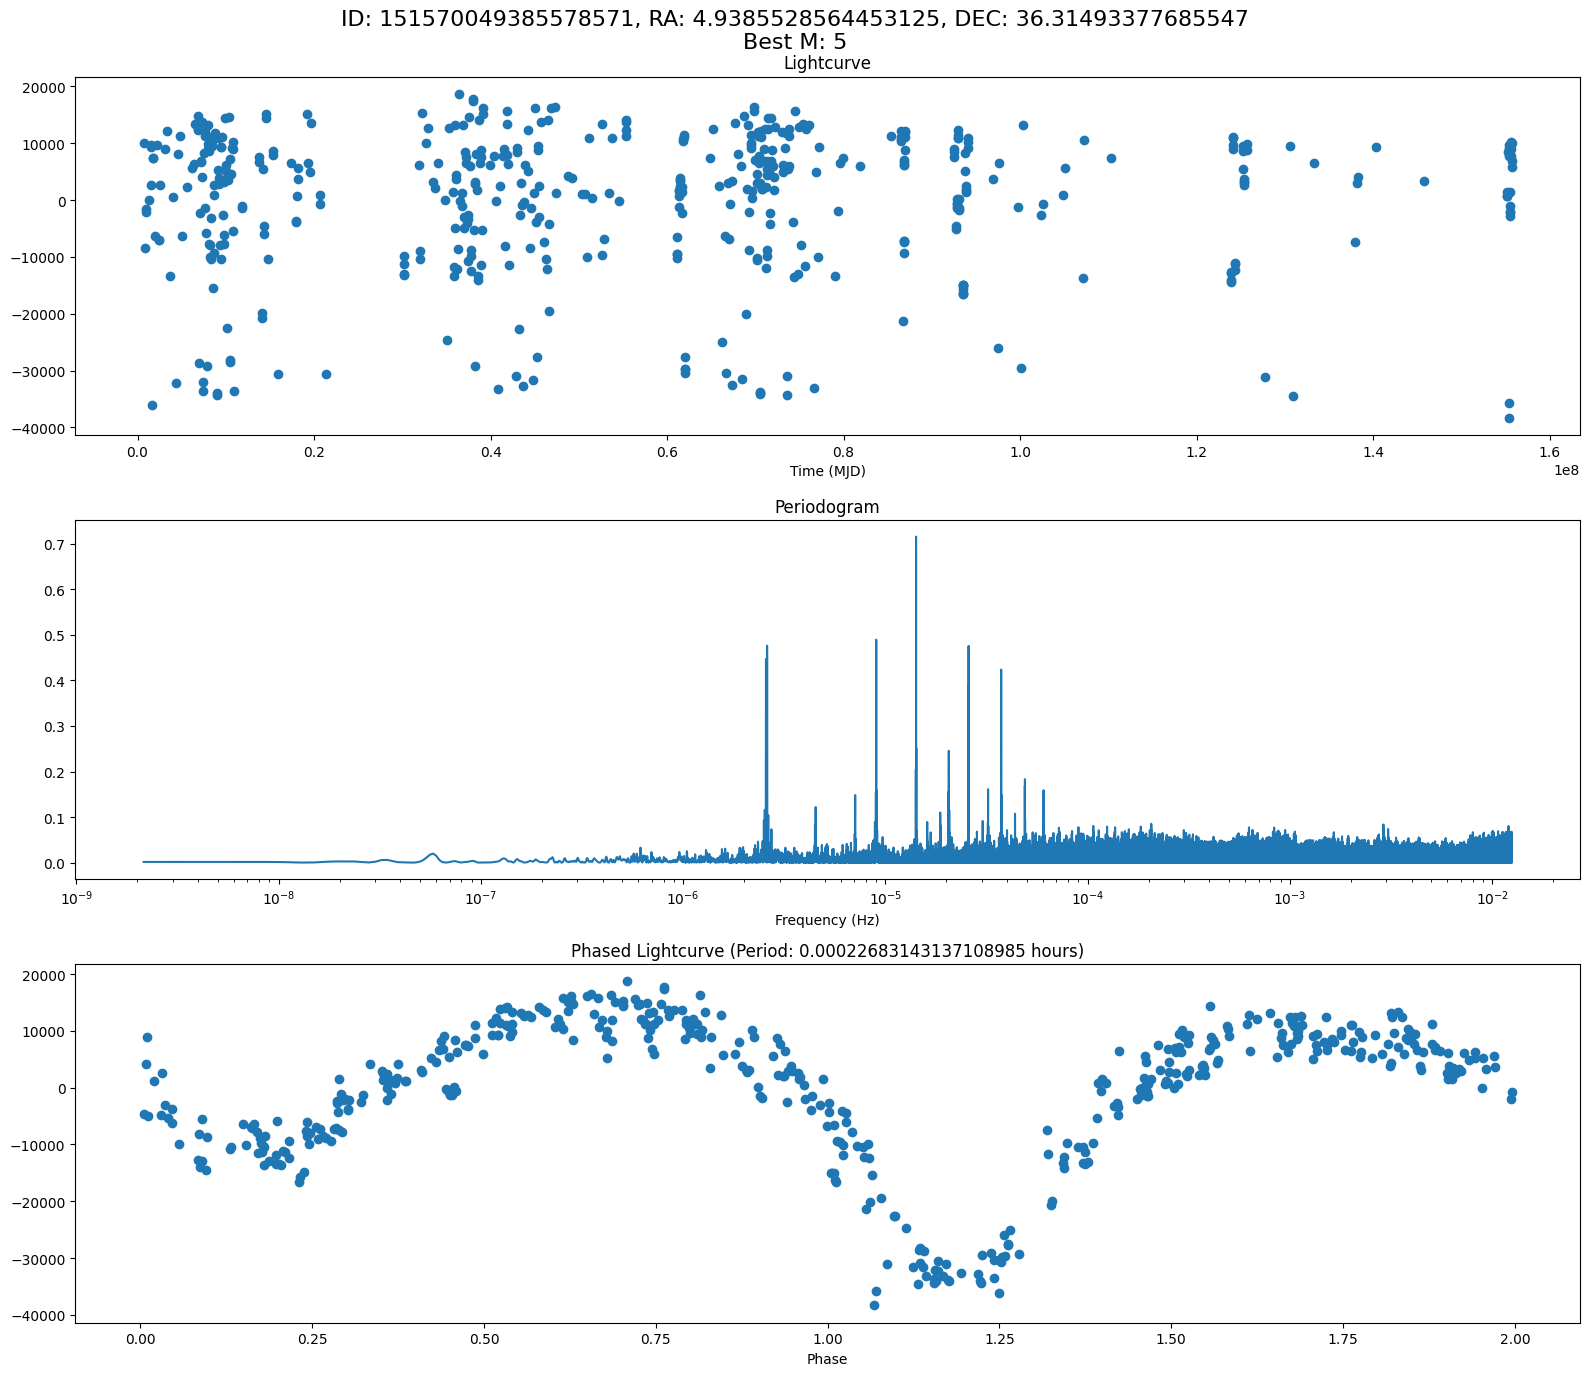

In [41]:
plot_periodicity(candidate, phot, ls_pgram, best_period, show_plot=True, figsize=(16,14))

Now, let's try FPW. This section is optionally and requires the `fpw` module. If you don't have it, you will not be able to run this section.

*Note: the `run_fpw` method requires the numpy arrays it takes as an input to be "C-contiguous". This is already enforced by the `retrieve_objs_lightcurve` method, but the order is lost after destructuring the light curve data. So in general (with the ZVAR data or your own data), make sure the numpy arrays are C-contiguous before passing them to the `run_fpw` method.*

Best FPW period: 0.0340 days


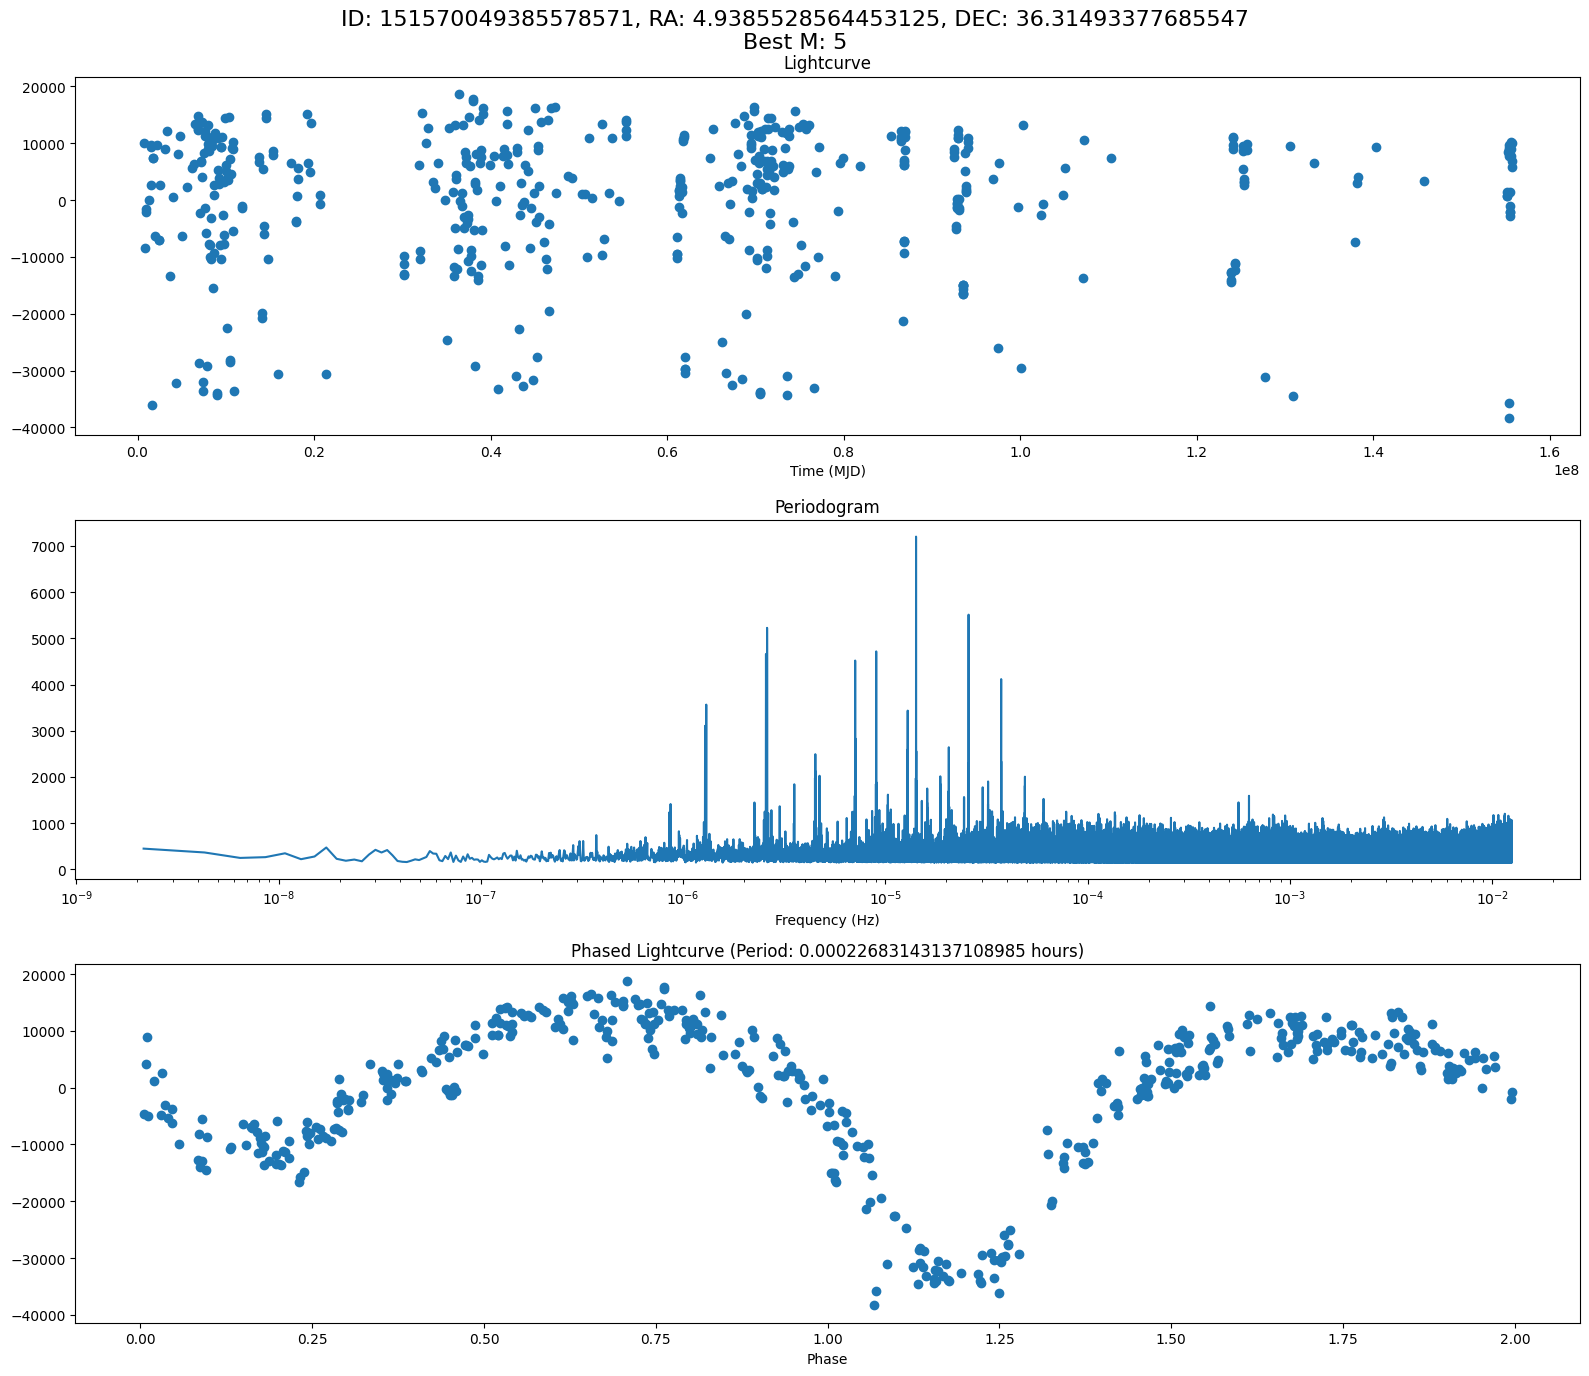

In [42]:
if fpw is None:
    raise ImportError("Could not import fpw. You will not be able to use the fpw module.")

f_grid = freq_grid(phot[0])

# we make sure all arrays are C-contiguous
time, flux, flux_err = [np.ascontiguousarray(x) for x in phot[:3]]

fpw_pgram = fpw.run_fpw(time, flux, flux_err, f_grid, 5) # where 5 is the bin size
fpw_pgram[np.isnan(fpw_pgram)] = 0
best_period = 1/fgrid[np.argmax(fpw_pgram)] / 3600 / 24 # best period in days, where the power is maximized

print(f"Best FPW period: {best_period/24:.4f} days")

plot_periodicity(candidate, phot, fpw_pgram, best_period, show_plot=True, figsize=(16,14))

You might notice that the period reported here is slightly different from the period found in the variability candidate dataset. This is simply because the lightcurve data cleaned by the `retrieve_objs_lightcurve` method is not identical to what the FPW pipeline running on the server would use. For example, here we did not apply any outlier rejection (clipping) to the light curve data, which could potentially yield better periods.

Let's try it in the next cell:

In [43]:
# first let's remove the non-detections to simplify the clipping, if there are any
det_mask = ~np.isnan(phot[1])
det_phot = phot[:, det_mask]

# then let's remove the outliers, where the flux is more than 1.483 times the median absolute deviation
valid_mask = np.where(np.abs(det_phot[1]) < 1.483 * median_abs_deviation(det_phot[1]))[0]
clipped_phot = det_phot[:, valid_mask]

time, flux, flux_err = [np.ascontiguousarray(x) for x in clipped_phot[:3]]

fpw_pgram = fpw.run_fpw(time, flux, flux_err, f_grid, 5) # where 5 is the bin size
fpw_pgram[np.isnan(fpw_pgram)] = 0
best_period = 1/fgrid[np.argmax(fpw_pgram)]

print(f"Best period: {best_period/3600:.4f} hours")

Best period: 19.5982 hours


Unfortunately for this specific example, the result does not seem to change after clipping, simply because this lightcurve is already very clean. However, in general, it is a good idea to clip the lightcurve data before running FPW, to remove outliers that could potentially affect the period finding.